# Setup

In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm_notebook
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score, cohen_kappa_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# Import Data

In [2]:
impt_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [3]:
test_data

,0,1,2,3,4,5
0,3,2,3,4,1,4
1,1,1,5,6,8,7
2,4,4,8,5,4,2
3,2,1,6,8,8,2
4,3,2,1,3,5,2
...,...,...,...,...,...,...
5606,4,1,7,4,6,1
5607,3,3,8,2,8,1
5608,3,2,2,1,2,6
5609,4,3,2,4,8,5


In [4]:
labels_pd = impt_data.pop("6")
labels_test_pd = test_data

In [5]:
data_pd = impt_data
data_test_pd = test_data

In [6]:
data = data_pd.to_numpy()
labels = labels_pd.to_numpy()
X_test = data_test_pd.to_numpy()
print(data.shape)
print(X_test.shape)

(22444, 6)
(5611, 6)


# Train Test Split

In [7]:
X_train, X_val, Y_train, Y_val = train_test_split(data, labels, stratify = labels, random_state = 0, test_size = 0.3)

In [8]:
X_train, Y_train, X_val, Y_val, X_test = map(torch.tensor, (X_train, Y_train, X_val, Y_val, X_test))

In [9]:
X_train, Y_train, X_val, Y_val, X_test = X_train.float(), Y_train.float(), X_val.float(), Y_val.float(), X_test.float()

In [102]:
def accuracy(Y, Y_hat):
#     f1_scr = f1_score(Y, Y_hat, average='macro')
    mae = mean_absolute_error(Y, Y_hat)
#     print("MAE: {}, F1 Score: {}".format(mae))
    return(mae)

# SVM

In [149]:
device = torch.device("cpu")

X_train = X_train.to(device)
X_val = X_val.to(device)
X_test  = X_test.to(device)
Y_train = Y_train.to(device)
Y_val = Y_val.to(device)

In [150]:
from sklearn.svm import SVC

In [ ]:
clf = SVC(kernel='poly',degree = 5, C = 2, gamma = 'auto')
clf.fit(X_train,Y_train)

In [ ]:
y_pred = clf.predict(X_val)
accuracy(Y_val,y_pred)

In [ ]:
submission = clf.predict(X_test.cpu())

# KNN 

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

In [ ]:
knn.fit(X_train, Y_train)

In [ ]:
y_pred = knn.predict(X_val.cpu())
accuracy(Y_val.cpu(),y_pred)

In [ ]:
submission = knn.predict(X_test)

# CSV Submission

In [ ]:
import csv

with open('submission.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['depth'])
    for i in range(submission.shape[0]):
        writer.writerow([submission[i]])

In [82]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train = X_train.to(device)
X_val = X_val.to(device)
X_test  = X_test.to(device)
Y_train = Y_train.to(device)
Y_val = Y_val.to(device)

In [103]:
class FF_Network(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(0)
        self.net = nn.Sequential(
            nn.Linear(6, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64,32),
            nn.BatchNorm1d(32),
            nn.ReLU(), 
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Linear(16, 1),
        )
           
    def forward(self, X):
        return(self.net(X))

In [104]:
ff_n = FF_Network().to(device)
loss_fn = nn.MSELoss()

In [143]:
def train(X, Y, model, loss_fn = loss_fn, lr = 0.02, epochs = 2500, batch_size = 1024):
    loss_b = []
    acc_b = []
    acc = 0
    ff_n.load_state_dict(torch.load('./weights'))
    optm = optim.SGD(ff_n.parameters(), lr = lr)
    for i in tqdm_notebook(range(epochs)):
        for i in range(X.shape[0] // batch_size):
            local_X, local_Y = X[i*batch_size:(i+1)*batch_size,], Y[i*batch_size:(i+1)*batch_size,]
            Y_hat = model.forward(local_X)
            loss = loss_fn(Y_hat.squeeze(), local_Y)
            Y_hat, local_Y = Y_hat.cpu(), local_Y.cpu()
            acc = accuracy(Y_hat.detach().numpy().squeeze(), local_Y.numpy())
            loss_b.append(loss.item())
            acc_b.append(acc)
            loss.backward()
            optm.step()
            optm.zero_grad()
    return(loss_b, acc_b, acc)

In [144]:
%%time
loss_b, acc_b, acc_score = train(X_train, Y_train, ff_n, loss_fn, lr = 5e-4, epochs = 20000, batch_size = 8192)


Wall time: 8min 52s


In [145]:
y_pred = ff_n(X_val)
y_pred, Y_val = y_pred.cpu(), Y_val.cpu()
print(y_pred.detach().numpy(), Y_val.detach().numpy())
accuracy(y_pred.detach().numpy(), Y_val.detach().numpy())

[[ 7.4405665]
 [ 4.6661887]
 [10.044451 ]
 ...
 [14.707012 ]
 [ 9.997486 ]
 [ 7.0923123]] [13.  8. 12. ... 15. 11.  8.]


0.65629816

Text(0, 0.5, 'mae')

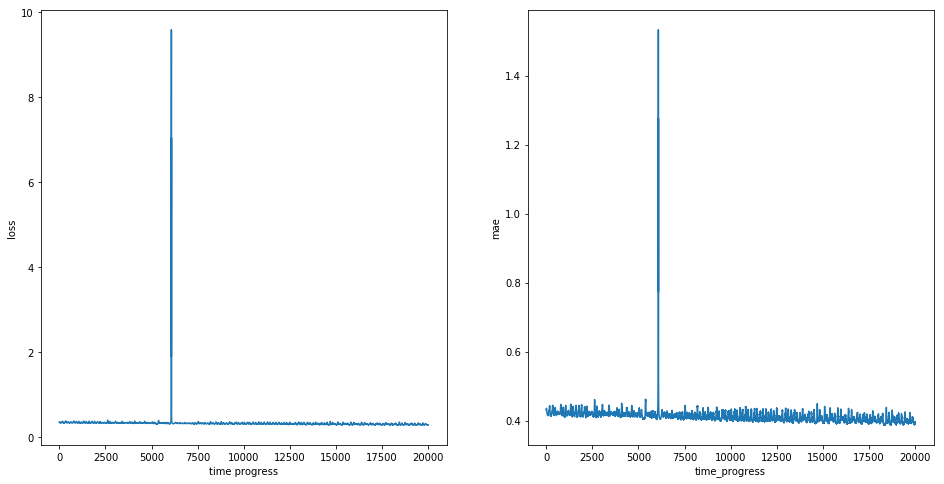

In [146]:
fig = plt.figure(figsize = (16, 8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(loss_b)
ax1.set_xlabel('time progress')
ax1.set_ylabel('loss')
ax2.plot(acc_b)
ax2.set_xlabel('time_progress')
ax2.set_ylabel('mae')

In [142]:
torch.save(ff_n.state_dict(), './weights')